In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from tqdm.notebook import tqdm
from torch.nn import Conv2d
from torch.nn import CrossEntropyLoss
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sequential
from torch.nn import Sigmoid
from torch.nn import Softmax
from torch.optim import Adam
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
from typing import List
from typing import Tuple
from torch import Tensor

About the CIFAR10 dataset...

In [38]:
# Where the dataset should be stored
DATA_PATH = './data'

# Path to save visuals
OUT_PATH = '/home/sbaldasty/Code/github/sbaldasty/bitflippin.com/static/article/membership-inference'

# Number of classes in the dataset
N_CLASSES = 10

I'm sharing the test set across the victim and shadow models. About how the rest of the training set should be split up...

In [3]:
# Fraction of training data for victim model, rest is for adversary
VICTIM_TRAIN_FRAC = 0.2

# Fraction of adversarial training data per shadow model training
SHADOW_TRAIN_FRAC = 0.2

# Number of shadow models
N_SHADOW_MODELS = 20

About hyperparameters for training... Probably want the epochs and victim and shadow models to be the same?

In [4]:
N_CIFAR_EPOCHS = 100
N_ATTACK_EPOCHS = 10

Some configuration choices...

In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Synchronous CUDA ops only
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

/home/sbaldasty/.pyenv/versions/3.13.2/envs/adversarial-ai/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Create a model for CIFAR-10. The model is based...

In [6]:
def cifar_model() -> Module:
    return Sequential(
        Conv2d(3, 16, kernel_size=3, padding=1),
        Tanh(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(16, 16, kernel_size=3),
        Tanh(),
        MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        Linear(784, N_CLASSES),
        Tanh(),
        Softmax(dim=1))

Attack model will have two branches. Paper didn't talk about how they did this so I'm experimenting here... Sigmoid is allegedly good for binary classification.

In [7]:
def attack_model() -> Module:
    return Sequential(
        Linear(10, 128),
        ReLU(),
        Linear(128, 128),
        ReLU(),
        Linear(128, 1),
        Sigmoid())

Just some nice generic visualization of training process. Works for all of victim, shadow, and attack models all (not my code!)

In [8]:
def plot_training_history(losses, accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    ax2.plot(accuracies)
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

How to train and evaluate a victim or shadow model. Shoud epochs and learning rate be different for the shadow models? (mostly not my code!)

In [9]:
def traincifar10(loader, epochs):
    model = cifar_model().to(device)
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar for training batches
        progress_bar = tqdm(loader, desc=f'Epoch {epoch + 1}/{epochs}')
        
        for i, data in enumerate(progress_bar):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / ( i + 1),
                'acc': 100.0 * correct / total
            })

            del inputs, labels
        
        # Store epoch metrics
        epoch_loss = running_loss / len(loader)
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        #model.eval()

    return model.cpu(), train_losses, train_accuracies

def evaluatecifar10(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    predvecs = []

    with torch.no_grad():
        for data in tqdm(dataloader, desc='Evaluating'):
            images, labels = data[0].to(device), data[1].to(device)
            predvec = model(images)
            predvecs.append(predvec)
            _, predicted = torch.max(predvec.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return torch.cat(predvecs)

How to train and evaluate an attack model...

In [32]:
def trainattack(dataloader):
    model = attack_model().to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    #criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    for epoch in range(N_ATTACK_EPOCHS):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar for training batches
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{N_ATTACK_EPOCHS}')
        
        for i, data in enumerate(progress_bar):
            traindata, labels = data[0].to(device), data[1].to(device)

            # Create fresh tensors
            #traindata = traindata.clone().detach()
            #labels = labels.clone().detach()

            # I'm not really sure why this is necessary, but it is
            # Output has shape (128, 1) but labels has (128,)
            #labels = labels.view(-1, 1).float()

            optimizer.zero_grad()
            # outputs = model(traindata)
            outputs = model(traindata).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate accuracy
            predicted = (outputs >= 0.5).float()
            #predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / ( i + 1),
                'acc': 100.0 * correct / total
            })
        
        # Store epoch metrics
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
    return model.cpu(), train_losses, train_accuracies

def evaluate_attack(model, dataloader):
    model.eval()
    model = model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for data in tqdm(dataloader, desc='Evaluating'):
            input, labels = data[0].to(device), data[1].to(device)
            labels = labels.view(-1, 1).float()
            istrain = model(input)
            predicted = (istrain > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

Loading the CIFAR10 training and test sets...

In [11]:
def split_cifar_dataset(victim_frac: float) -> Tuple[Dataset, Dataset, Dataset]:
    tr = Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    train_set = CIFAR10(DATA_PATH, train=True, download=True, transform=tr)
    test_set = CIFAR10(DATA_PATH, train=False, download=True, transform=tr)

    victim_size = int(victim_frac * len(train_set))
    splits = [victim_size, len(train_set) - victim_size]
    victim_set, adversary_set = random_split(train_set, splits)

    return victim_set, adversary_set, test_set

Convert a `Dataset` into two tensors representing the features and labels.

In [12]:
def dataset_to_tensors(dataset: Dataset) -> List[Tensor]:
    loader = DataLoader(dataset, batch_size=len(dataset))
    return next(iter(loader))

GPU memory management...

In [13]:
def run_on_gpu(model: Module, features: Tensor) -> Tensor:
    model = model.to(device)
    features = features.to(device)
    output = model(features)
    del model, features
    torch.cuda.empty_cache()
    return output.cpu()

Create two disjoint subsets of equal size from the adversarial `dataset` for the purpose of training and testing a shadow model. Each dataset uses `frac` of the total data available to the adversary.

In [14]:
def disjoint_subsets(dataset: Dataset, frac: float) -> Tuple[Dataset, Dataset]:
    dataset_size = len(dataset)
    subset_size = int(dataset_size * frac)
    indexes = np.random.choice(dataset_size, 2 * subset_size, replace=False)
    midpoint = len(indexes) // 2
    train_set = Subset(dataset, indexes[:midpoint])
    test_set = Subset(dataset, indexes[midpoint:])
    return train_set, test_set

Generate attack model data for training or testing by feeding the `dataset` through a victim or shadow `model`. The generated data will be the model's confidence vector. The `label` should be 1 if the model was trained on the dataset and 0 if it was not.

In [15]:
def attack_data(model: Module, dataset: Dataset, label: int) -> Dataset:
    confidences = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=64):
            images, _ = batch[0], batch[1]
            confidences.append(run_on_gpu(model, images))

    _, cifar_labels = dataset_to_tensors(dataset)
    attack_labels = torch.full([len(dataset)], label)
    confidences = torch.cat(confidences)
    return TensorDataset(confidences, cifar_labels, attack_labels)

Generate balanced attack model training or testing data from two...

In [16]:
def balanced_attack_data(model: Module, train_set: Dataset, test_set: Dataset) -> Dataset:
    train_attack = attack_data(model, train_set, 1)
    test_attack = attack_data(model, test_set, 0)
    return ConcatDataset([train_attack, test_attack])

Generate attack model training data from a shadow model trained on `frac` of the adversarial `dataset`. The dataset will include the shadow model's confidence vectors for all the data it was trained on, and an equal number of confidence vectors for other adversarial data it was _not_ trained on.

In [17]:
# Exclude
def train_cifar_model(train_set: Dataset) -> Module:
    loader = DataLoader(train_set, batch_size=128, shuffle=True)
    model, asdf1, asdf2 = traincifar10(loader, N_CIFAR_EPOCHS)
    return model

In [18]:
# Exclude
def train_attack_model(train_set: Dataset) -> Module:
    loader = DataLoader(train_set, batch_size=128, shuffle=True)
    model, asdf1, asdf2 = trainattack(loader)
    return model

In [19]:
def shadow_attack_data(n_shadows: int, dataset: Dataset, frac: float) -> Dataset:
    attack_datasets = []
    for _ in range(n_shadows):
        train_set, test_set = disjoint_subsets(dataset, frac)
        model = train_cifar_model(train_set)
        attack_datasets.append(balanced_attack_data(model, train_set, test_set))
    return ConcatDataset(attack_datasets)

Generate attack model testing data from a victim model. The dataset will include the victim model's confidence vectors on all its testing data, and an equal number of confidence vectors randomly selected from its training vector. This ensures it will be _balanced_.

In [20]:
def victim_attack_data(model: Module, train_set: Dataset, test_set: Dataset) -> Dataset:
    indexes = np.random.choice(len(train_set), len(test_set), replace=False)
    train_subset = Subset(train_set, indexes)
    return balanced_attack_data(model, train_subset, test_set)

In [21]:
def filter_by_cifar_label(dataset: Dataset, label: int) -> Dataset:
    confidences, cifar_labels, attack_labels = dataset_to_tensors(dataset)
    filtered_confidences = confidences[cifar_labels == label]
    filtered_attack_labels = attack_labels[cifar_labels == label]
    return TensorDataset(filtered_confidences, filtered_attack_labels)

In [22]:
def train_attack_models(n_labels: int, dataset: Dataset) -> List[Module]:
    models = []
    for label in range(n_labels):
        filtered_dataset = filter_by_cifar_label(dataset, label)
        model = train_attack_model(filtered_dataset)
        models.append(model)
    return models

Putting it all together...

In [23]:
victim_set, adversary_set, test_set = split_cifar_dataset(VICTIM_TRAIN_FRAC)

In [24]:
victim_model = train_cifar_model(victim_set)

Epoch 1/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/79 [00:00<?, ?it/s]

In [25]:
attack_test_set = victim_attack_data(victim_model, victim_set, test_set)

In [26]:
complete_attack_train_set = shadow_attack_data(N_SHADOW_MODELS, adversary_set, SHADOW_TRAIN_FRAC)

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/63 [00:00<?, ?it/s]

In [27]:
attack_models = train_attack_models(N_CLASSES, complete_attack_train_set)

Epoch 1/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/248 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/251 [00:00<?, ?it/s]

In [33]:
labels = list(range(N_CLASSES))
accuracies = []
for label in labels:
    filtered_dataset = filter_by_cifar_label(attack_test_set, label)
    model = attack_models[label]
    accuracies.append(evaluate_attack(model, filtered_dataset))

Evaluating:   0%|          | 0/2024 [00:00<?, ?it/s]

Accuracy: 61.81%


Evaluating:   0%|          | 0/1996 [00:00<?, ?it/s]

Accuracy: 66.53%


Evaluating:   0%|          | 0/1983 [00:00<?, ?it/s]

Accuracy: 61.98%


Evaluating:   0%|          | 0/1990 [00:00<?, ?it/s]

Accuracy: 61.81%


Evaluating:   0%|          | 0/1995 [00:00<?, ?it/s]

Accuracy: 62.66%


Evaluating:   0%|          | 0/1981 [00:00<?, ?it/s]

Accuracy: 62.39%


Evaluating:   0%|          | 0/2029 [00:00<?, ?it/s]

Accuracy: 60.62%


Evaluating:   0%|          | 0/2022 [00:00<?, ?it/s]

Accuracy: 63.80%


Evaluating:   0%|          | 0/1980 [00:00<?, ?it/s]

Accuracy: 63.89%


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Accuracy: 64.15%


As an experimenter, I don't care too much about testing the attack model on a dataset other than what I get from the victim model. As an attacker, I might care though: I won't know if my membership inference predictions against the victim model are right, and I might want to know when I deploy my attack model against the victim, how likely is it that they are. Generating test data from the victim model...

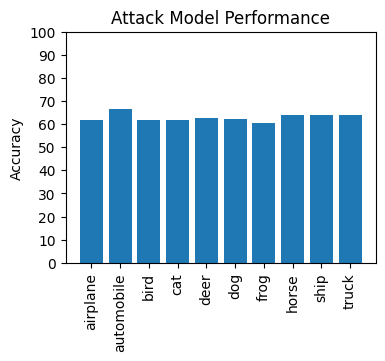

In [45]:
label_words = CIFAR10(DATA_PATH, download=True).classes

plt.figure(figsize=(4, 3))
plt.bar(label_words, accuracies)
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 101, 10))
plt.title('Attack Model Performance')
plt.xticks(labels, rotation=90)

plt.savefig(
    f'{OUT_PATH}/attack-model-performance.png',
    bbox_inches='tight',
    pad_inches=0.1,
    transparent=True)

plt.show()